In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
df_patient_info = pd.read_csv('../T1DiabetesGranada/Patient_info.csv', dtype={'Number_of_days_with_measures':np.int32, 'Number_of_measurements':np.int32})
df_glucose_measurements = pd.read_csv('../T1DiabetesGranada/Glucose_measurements.csv', dtype={'Measurement' : np.int16})
df_biochemical_parameters = pd.read_csv('../T1DiabetesGranada/Biochemical_parameters.csv')
df_diagnostics = pd.read_csv('../T1DiabetesGranada/Diagnostics.csv')

In [4]:
df_patient_info.name = 'Patient_info.csv'
df_glucose_measurements.name = 'Glucose_measurements.csv'
df_biochemical_parameters.name = 'Biochemical_parameters.csv'
df_diagnostics.name = 'Diagnostics.csv'

In [5]:
datasets_list = [df_patient_info, df_glucose_measurements, df_biochemical_parameters, df_diagnostics]
datasets_list.reverse()

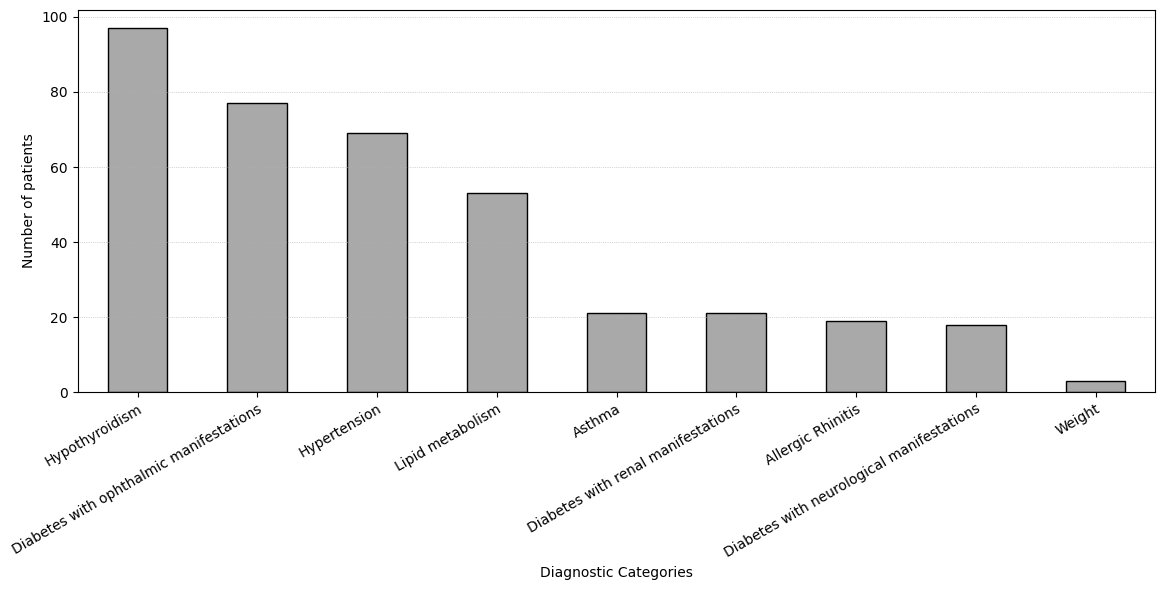

Number of unique patients per category:
Hypothyroidism: 97
Diabetes with ophthalmic manifestations: 77
Hypertension: 69
Lipid metabolism: 53
Asthma: 21
Diabetes with renal manifestations: 21
Allergic Rhinitis: 19
Diabetes with neurological manifestations: 18
Weight: 3


In [6]:
# Define the broader categories and their corresponding codes
category_mapping = {
    'Hypothyroidism': ['244.3', '244.8', '244.9', '244'],
    'Hypertension': ['401', '401.1', '401.9'],
    'Diabetes with ophthalmic manifestations': ['250.5', '250.51', '250.53'],
    'Lipid metabolism': ['272', '272.1', '272.2', '272.4', '272.8'],
    'Weight': ['278', '278.01', '278.02'],
    'Allergic Rhinitis': ['477', '477.9'],
    'Diabetes with renal manifestations': ['250.4', '250.41'],
    'Asthma': ['493.9', '493', '493.01', '493.91'],
    'Diabetes with neurological manifestations': ['250.6', '250.63']
}

# Create a function to map codes to broader categories
def map_to_category(code):
    code_str = str(code)
    for category, codes in category_mapping.items():
        if code_str in codes:
            return category
    return 'Other'

# Apply the mapping to create a new column for broader categories
df_diagnostics['Broad_Category'] = df_diagnostics['Code'].apply(map_to_category)

# For each patient, get the unique broader categories they have
# First, group by Patient_ID and collect all broader categories
patient_categories = df_diagnostics.groupby('Patient_ID')['Broad_Category'].unique()

# Count how many patients have each broader category
category_counts = {}
for categories in patient_categories:
    for category in categories:
        if category != 'Other':  # Skip 'Other' category
            if category in category_counts:
                category_counts[category] += 1
            else:
                category_counts[category] = 1

# Convert to Series and sort by count
category_series = pd.Series(category_counts).sort_values(ascending=False)

# Create the plot
ax = category_series.plot(kind='bar', figsize=(12, 6), color='darkgray', edgecolor="black")
ax.grid(axis='y', linestyle=':', linewidth='0.5')

# Format x-axis labels with rotation for better readability
x_labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

# Format y-axis - adjust range based on actual counts
max_count = category_series.max()
y_ticks_values = np.arange(0, max_count + 20, 20)
y_ticks_labels = list(map(str, y_ticks_values))
y_ticks = ax.yaxis.set_ticks(y_ticks_values)
y_labels = ax.yaxis.set_ticklabels(y_ticks_labels)

# Set labels
y_title = ax.set_ylabel('Number of patients')
x_title = ax.set_xlabel('Diagnostic Categories')

plt.tight_layout()
plt.show()

# Print the counts to verify
print("Number of unique patients per category:")
for category, count in category_series.items():
    print(f"{category}: {count}")

In [8]:
# Combine date + time if needed
df_glucose_measurements['Timestamp'] = pd.to_datetime(
    df_glucose_measurements['Measurement_date'] + ' ' + df_glucose_measurements['Measurement_time']
)

df_glucose_measurements = df_glucose_measurements.sort_values(['Patient_ID', 'Timestamp'])

# Define ranges
LOW = 70
HIGH = 180

def compute_metrics(group):
    # Explicitly select only the measurement column, excluding grouping columns
    values = group['Measurement']
    total = len(values)

    tir = ((values >= LOW) & (values <= HIGH)).mean() * 100         # percentage
    tbr = (values < LOW).mean() * 100
    tar = (values > HIGH).mean() * 100

    cv = values.std() / values.mean() if values.mean() != 0 else None

    return pd.Series({
        'TIR': tir,
        'TBR': tbr,
        'TAR': tar,
        'CV': cv
    })

# Fix: Add include_groups=False to exclude grouping columns from the apply operation
df_metrics = df_glucose_measurements.groupby('Patient_ID').apply(compute_metrics, include_groups=False).reset_index()

In [9]:
df_metrics.head()

,Patient_ID,TIR,TBR,TAR,CV
0,LIB193263,52.567473,1.941828,45.490699,0.352605
1,LIB193264,62.474335,8.033748,29.491918,0.418371
2,LIB193265,64.462384,15.664720,19.872896,0.519678
3,LIB193266,68.606712,1.703189,29.690099,0.359984
4,LIB193267,52.204465,1.592764,46.202771,0.380337


In [10]:
# Filter only A1c measurements
df_a1c = df_biochemical_parameters[df_biochemical_parameters['Name'] == 'Glycated hemoglobin (A1c)']

# Compute mean and SD per patient
df_a1c_metrics = df_a1c.groupby('Patient_ID')['Value'].agg(
    A1c_mean='mean',
    A1c_SD='std'
).reset_index()

# Merge into existing df_metrics
df_metrics = df_metrics.merge(df_a1c_metrics, on='Patient_ID', how='left')

In [11]:
df_metrics.head()

,Patient_ID,TIR,TBR,TAR,CV,A1c_mean,A1c_SD
0,LIB193263,52.567473,1.941828,45.490699,0.352605,NaN,NaN
1,LIB193264,62.474335,8.033748,29.491918,0.418371,NaN,NaN
2,LIB193265,64.462384,15.664720,19.872896,0.519678,7.616667,0.617792
3,LIB193266,68.606712,1.703189,29.690099,0.359984,8.640000,4.022188
4,LIB193267,52.204465,1.592764,46.202771,0.380337,8.025000,0.433013


In [12]:
# Assume study baseline date is January 1, 2018
STUDY_YEAR = 2018

# Select only the relevant columns from df_patient_info
demographics = df_patient_info[['Patient_ID', 
                                'Sex', 
                                'Birth_year', 
                                'Number_of_days_with_measures', 
                                'Number_of_measurements', 
                                'Number_of_biochemical_parameters', 
                                'Number_of_diagnostics']].drop_duplicates(subset='Patient_ID')

# Compute Age at study baseline
demographics['Age'] = STUDY_YEAR - demographics['Birth_year']

# Drop Birth_year if you only want Age
demographics = demographics.drop(columns=['Birth_year'])

# Merge into df_metrics
df_metrics = df_metrics.merge(demographics, on='Patient_ID', how='left')

In [13]:
df_metrics.head()

,Patient_ID,TIR,TBR,TAR,CV,A1c_mean,A1c_SD,Sex,Number_of_days_with_measures,Number_of_measurements,Number_of_biochemical_parameters,Number_of_diagnostics,Age
0,LIB193263,52.567473,1.941828,45.490699,0.352605,NaN,NaN,M,648,60097,NaN,1.0,53
1,LIB193264,62.474335,8.033748,29.491918,0.418371,NaN,NaN,F,326,26786,NaN,3.0,43
2,LIB193265,64.462384,15.664720,19.872896,0.519678,7.616667,0.617792,F,581,46575,120.0,NaN,38
3,LIB193266,68.606712,1.703189,29.690099,0.359984,8.640000,4.022188,M,500,55307,74.0,2.0,20
4,LIB193267,52.204465,1.592764,46.202771,0.380337,8.025000,0.433013,F,647,55500,177.0,1.0,38


In [14]:
# List of biochemical parameters of interest
parameters_of_interest = [
    'Alanine transaminase (GPT)',
    'Albumin (urine)',
    'Chlorine',
    'Creatinine',
    'Creatinine (urine)',
    'Gamma-glutamyl Transferase (GGT)',
    'Glucose',
    'HDL cholesterol',
    'Potassium',
    'Sodium',
    'Thyrotropin (TSH)',
    'Total cholesterol',
    'Triglycerides',
    'Uric acid'
]

# Filter the dataframe to keep only these parameters
df_biochem_filtered = df_biochemical_parameters[
    df_biochemical_parameters['Name'].isin(parameters_of_interest)
]

# Compute mean per patient for each parameter
df_biochem_means = df_biochem_filtered.groupby(['Patient_ID', 'Name'])['Value'].mean().unstack()

# Optional: rename columns to indicate they are means
df_biochem_means = df_biochem_means.add_suffix('_mean').reset_index()

# Merge into df_metrics
df_metrics = df_metrics.merge(df_biochem_means, on='Patient_ID', how='left')


In [15]:
df_metrics.head()

,Patient_ID,TIR,TBR,TAR,CV,A1c_mean,A1c_SD,Sex,Number_of_days_with_measures,Number_of_measurements,...,Creatinine (urine)_mean,Gamma-glutamyl Transferase (GGT)_mean,Glucose_mean,HDL cholesterol_mean,Potassium_mean,Sodium_mean,Thyrotropin (TSH)_mean,Total cholesterol_mean,Triglycerides_mean,Uric acid_mean
0,LIB193263,52.567473,1.941828,45.490699,0.352605,NaN,NaN,M,648,60097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIB193264,62.474335,8.033748,29.491918,0.418371,NaN,NaN,F,326,26786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIB193265,64.462384,15.664720,19.872896,0.519678,7.616667,0.617792,F,581,46575,...,140.260000,10.200000,186.900000,73.857143,4.260000,136.400000,4.173250,205.250000,94.375000,4.288889
3,LIB193266,68.606712,1.703189,29.690099,0.359984,8.640000,4.022188,M,500,55307,...,146.402500,15.500000,157.571429,49.200000,3.751429,139.428571,1.539750,153.000000,63.200000,4.800000
4,LIB193267,52.204465,1.592764,46.202771,0.380337,8.025000,0.433013,F,647,55500,...,117.282727,19.583333,172.071429,56.916667,4.678667,138.600000,2.692364,180.583333,75.166667,3.763636


In [16]:
# List of the categories we want binary columns for
categories = list(category_mapping.keys())

# Create a DataFrame where each row is a patient, each column is a category
# Initialize all values to 0
df_diag_binary = pd.DataFrame(0, index=df_metrics['Patient_ID'], columns=categories)
df_diag_binary.index.name = 'Patient_ID'
df_diag_binary = df_diag_binary.reset_index()

# Fill in 1s where patients have the category
for patient_id, cat_list in patient_categories.items():
    for cat in cat_list:
        if cat in categories:
            df_diag_binary.loc[df_diag_binary['Patient_ID'] == patient_id, cat] = 1

# Merge the binary columns into df_metrics
df_metrics = df_metrics.merge(df_diag_binary, on='Patient_ID', how='left')

In [17]:
df_metrics.head()

,Patient_ID,TIR,TBR,TAR,CV,A1c_mean,A1c_SD,Sex,Number_of_days_with_measures,Number_of_measurements,...,Uric acid_mean,Hypothyroidism,Hypertension,Diabetes with ophthalmic manifestations,Lipid metabolism,Weight,Allergic Rhinitis,Diabetes with renal manifestations,Asthma,Diabetes with neurological manifestations
0,LIB193263,52.567473,1.941828,45.490699,0.352605,NaN,NaN,M,648,60097,...,NaN,0,0,0,1,0,0,0,0,0
1,LIB193264,62.474335,8.033748,29.491918,0.418371,NaN,NaN,F,326,26786,...,NaN,0,0,0,0,0,0,0,0,0
2,LIB193265,64.462384,15.664720,19.872896,0.519678,7.616667,0.617792,F,581,46575,...,4.288889,0,0,0,0,0,0,0,0,0
3,LIB193266,68.606712,1.703189,29.690099,0.359984,8.640000,4.022188,M,500,55307,...,4.800000,0,0,0,0,0,0,0,0,0
4,LIB193267,52.204465,1.592764,46.202771,0.380337,8.025000,0.433013,F,647,55500,...,3.763636,0,0,0,0,0,0,0,0,0


In [ ]:
# Save df_metrics to CSV in the current working directory
df_metrics.to_csv('df_metrics_CGM_biochem_demographics.csv', index=False)